# Predicting Bike Rentals

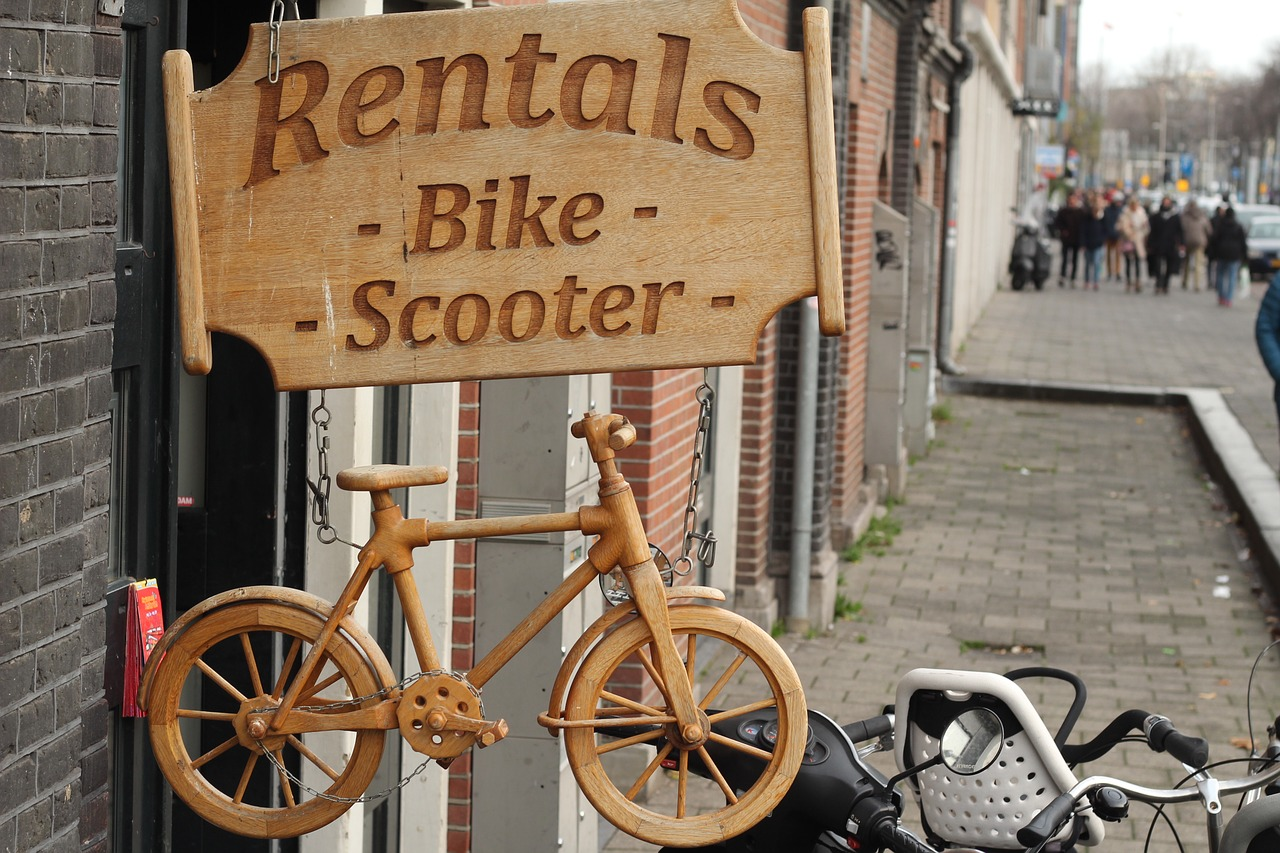

In this project, we'll work with the data on communal bike sharing by the hour or day in Washington, D.C., with the goal to predict the total number of bikes people rent in a given hour. 

The data was collected by [Hadi Fanaee-T](http://www.fanaee.com) at the [University of Porto](https://sigarra.up.pt/up/pt/web_base.gera_pagina?p_pagina=home) and can be downloaded from [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset), where we can find also detailed data documentation.
### Summary of Results
We've applied the linear regression, decision tree, and random forest machine learning techniques and obtained the most accurate models for the last one. The model recommended to be used for bike rental predictions is a random forest model with 70 trees and the maximum tree depth equal to 19.
## Data Downloading and Initial Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

bike_rentals = pd.read_csv('bike_rental_hour.csv')

print(f'\033[1mNumber of rows:\033[0m\t\t  {bike_rentals.shape[0]:,}'
      f'\033[1m\nNumber of columns:\033[0m \t  {bike_rentals.shape[1]:,}'
      f'\n\033[1mNumber of missing values:\033[0m {bike_rentals.isnull().sum().sum()}')

bike_rentals.head()

Number of rows:		  17,379
Number of columns: 	  17
Number of missing values: 0


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


- There are no missing values in the dataset.
- The dataset contains 17,379 rows, with each entry representing the number of bike rentals for a single hour of a single day.
- The `instant` column doesn't contain any useful information and has to be dropped:

In [2]:
bike_rentals = bike_rentals.drop('instant', axis=1)

- The number of bike rentals is the sum of registered (mostly) and casual users by hour:

In [3]:
bike_rentals['cnt'].equals(bike_rentals['casual'] + bike_rentals['registered'])

True

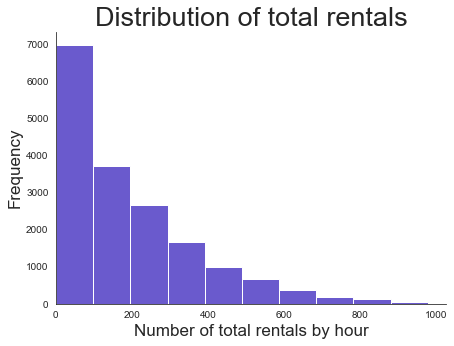

In [4]:
sns.set_style('white')
plt.figure(figsize=(7, 5))
plt.hist(bike_rentals['cnt'], color='slateblue')
plt.title('Distribution of total rentals', fontsize=27)
plt.xlabel('Number of total rentals by hour', fontsize=17)
plt.ylabel('Frequency', fontsize=17)
plt.xlim(0, None)
sns.despine()
plt.show()

- Most typically, there are up to 200 bike rentals by hour.
- On very rare occasions (probably, sporting competitions or cycle racing), the number of bike rentals can reach about 1,000 by hour.

Let's now take a look at what factors influence the number of bike rentals most of all:

In [5]:
bike_rentals.corr()['cnt'].sort_values(ascending=False).round(2).drop(['cnt'])

registered    0.97
casual        0.69
temp          0.40
atemp         0.40
hr            0.39
yr            0.25
season        0.18
mnth          0.12
windspeed     0.09
workingday    0.03
weekday       0.03
holiday      -0.03
weathersit   -0.14
hum          -0.32
Name: cnt, dtype: float64

Not surprisingly, the number of registered and casual users are the most influencing factors since they actually sum up to the total number of bike rentals. Other important factors are the temperature, feeling temperature, and the exact hour of the day. The most influencing negative factor is the humidity (practically meaning raining).
## Calculating New Features
To enhance the accuracy of our future machine learning models, let's calculate new features that better represent existing information or introduce new information.
### Time Label
Let's map the information from the `hr` column that contains the hours during which bikes are rented into a new column `time_label` that bundles similar times together into the parts of the day: *morning* (6.00-12.00), *afternoon* (12.00-18.00), *evening* (18.00-24.00), and *night* (0.00-6.00):

In [6]:
def assign_label(hour):
    if hour >= 6 and hour < 12:
        return 1
    elif hour >= 12 and hour < 18:
        return 2
    elif hour >= 18 and hour < 24:
        return 3
    else:
        return 4
    
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label) 

### Temperature Humidity Index
Temperature Humidity Index, or the discomfort index, accounts for the combined effect of environmental temperature and relative humidity and represents the degree of discomfort, aka heat stress, experienced by an individual in warm weather. The formula for its calculation:

*THI* = 0.8*T* + *RH*(*T* - 14.4) + 46.4

Let's calculate the THI value for each entry of our dataset:

In [7]:
bike_rentals['thi'] = 0.8 * bike_rentals['temp'] + bike_rentals['hum'] * (bike_rentals['temp'] - 14.4) + 46.4

## Feature Preprocessing and Selection
Before starting building predictive models, let's do some feature preprocessing.

First, let's re-run the correlation coefficients for `cnt` given that we have new features:

In [8]:
corr_cnt = bike_rentals.corr()['cnt'].sort_values(ascending=False).round(2).drop(['cnt'])
corr_cnt

registered    0.97
casual        0.69
temp          0.40
atemp         0.40
hr            0.39
thi           0.36
yr            0.25
season        0.18
mnth          0.12
windspeed     0.09
workingday    0.03
weekday       0.03
holiday      -0.03
weathersit   -0.14
hum          -0.32
time_label   -0.38
Name: cnt, dtype: float64

Ignoring the `registered` and `casual` features since they sum up to `cnt`, we see that all the other features correlate with the target feature, whether this correlation is very weak (e.g., `workingday`) or rather strong (e.g., `temp`). Since we don't have many features in our dataset, let's use for predictions also the features that demonstrate the weak correlation. Instead, we'll drop the unnecessary features (`registered`, `casual`, and `dteday`) and then check the remaining features for their collinearity:

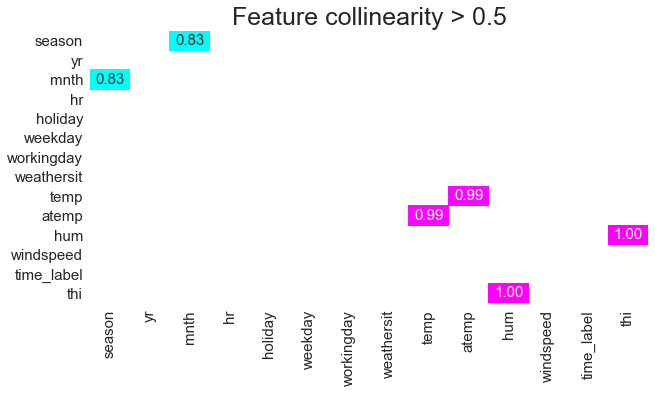

In [9]:
bike_rentals = bike_rentals.drop(['registered', 'casual', 'dteday'], axis=1)

# Creating a matrix of all features and those with the correlation coefficient higher than 0.5
corr_features = bike_rentals.corr().abs().drop('cnt').drop('cnt', axis=1)
corr_features_higher_05 = corr_features[(corr_features > 0.5) & (corr_features < 1)]

# Plotting the features with the collinearity higher than 0.5
sns.set_style('white')
plt.figure(figsize=(10, 5))
sns.heatmap(corr_features_higher_05, cmap='cool',
            annot=True, annot_kws={'size': 15}, fmt='.2f', 
            cbar=False)
plt.title('Feature collinearity > 0.5', fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

There are 3 pairs of strongly collinear features. To avoid biased predictions, let's leave in each pair the one that has a stronger correlation with the target variable:

In [10]:
# Constructing the table of the strongly collinear features
all_pairs = (corr_features.where(np.triu(np.ones(corr_features.shape), k=1).astype(np.bool))
                       .stack().sort_values(ascending=False))
collinear_pairs = all_pairs[all_pairs > 0.5].to_frame().reset_index()
collinear_pairs.columns = ['Feature_1', 'Feature_2', 'Coeff']

# Comparing the correlation coefficients of the collinear features with 'cnt'
# and eliminating from each pair the feature with the lowest one
for index, row in collinear_pairs.iterrows():
    feature_1 = row['Feature_1']
    feature_2 = row['Feature_2']
    feature_1_coef = corr_cnt[feature_1]
    feature_2_coef = corr_cnt[feature_2]
    if feature_1_coef > feature_2_coef:
        bike_rentals = bike_rentals.drop(feature_2, axis=1)
    else:
        bike_rentals = bike_rentals.drop(feature_1, axis=1)

print(f'\033[1mRemaining features:\033[0m\n{bike_rentals.columns}')

Remaining features:
Index(['season', 'yr', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit',
       'atemp', 'windspeed', 'cnt', 'time_label', 'thi'],
      dtype='object')


Now, we'll split the dataset into train and test sets for further modeling:

In [11]:
X_train, X_test, y_train, y_test = train_test_split(bike_rentals.drop('cnt', axis=1), bike_rentals['cnt'], 
                                                    test_size=0.8, random_state=0)

## Making Predictions

As an error metric to evaluate the performance of the models, we'll select the mean squared error since it applies to all the machine learning algorithms we're going to try: linear regression, decision tree, and random forest.
### Linear Regression
The advantages of this technique are that it's straightforward, fairly resistant to overfitting, and works best when predictors are linearly correlated to the target. However, usually it isn't the most accurate option because it can be prone to underfitting the data and not building a powerful enough model. 

Let's create a simple basic model: 

In [12]:
lr = LinearRegression()
lr.fit(X_train, y_train)

predictions_test = lr.predict(X_test)
mse_test = mean_squared_error(y_test, predictions_test)
print(f'MSE on the test set:  {mse_test:,.0f}')

predictions_train = lr.predict(X_train)
mse_train = mean_squared_error(y_train, predictions_train)
print(f'MSE on the train set: {mse_train:,.0f}')

MSE on the test set:  17,603
MSE on the train set: 17,254


As we can see, the MSE values on the test and train sets are rather comparable, meaning that at least the model isn't overfitted. 

There are no really useful parameters to tune for a linear regression model. One way to decrease the error could be trying different approaches for train-test splitting instead of a holdout validation (simple cross-validation or k-fold cross-validation). However, this wouldn't lead to a significant error decrease, and we have ahead 2 more powerful approaches to try, so for now, let's leave the linear regression model as it is and keep in mind the order of the error.
### Decision Tree
Let's now apply the decision tree technique and compare the resulting MSE values with those for the previous model, to be able to pick the right algorithm for our dataset.

The advantage of decision tree models is that they tend to predict outcomes much more reliably than linear regression models. However, they are usually quite complex and tend to overfit, especially if we don't tune any parameters. Also, they are highly unstable since any small change in the input data can result in a very different model.

Let's start with a basic decision tree:

In [13]:
clf = DecisionTreeRegressor(random_state=1)
clf.fit(X_train, y_train)

predictions_test = clf.predict(X_test)
mse_test = mean_squared_error(y_test, predictions_test)
print(f'MSE on the test set:  {mse_test:,.0f}')

predictions_train = clf.predict(X_train)
mse_train = mean_squared_error(y_train, predictions_train)
print(f'MSE on the train set: {mse_train:,.0f}')

MSE on the test set:  6,160
MSE on the train set: 0


We immediately see 2 things:
- both values are much lower than the corresponding values for the linear regression model above,
- a huge difference between the MSE values on the test and train sets, which is a clear sign of strong overfitting. 

Let's see if tuning the `random_state` parameter (leaving for now all the other parameters by default) can decrease the error:

In [14]:
def select_best_random_state(method='DecisionTreeRegressor', n_estimators=100, 
                             max_depth=None, min_samples_leaf=1, min_samples_split=2): 
    random_states = []
    for i in range(1000):
        if method == 'RandomForestRegressor':
            clf = RandomForestRegressor(n_estimators=n_estimators,
                                        max_depth=max_depth, min_samples_leaf=min_samples_leaf, 
                                        min_samples_split=min_samples_split, random_state=i)
        else:
            clf = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf, 
                                        min_samples_split=min_samples_split, random_state=i)
        clf.fit(X_train, y_train)
        predictions_test = clf.predict(X_test)
        mse_test = mean_squared_error(y_test, predictions_test)
        random_states.append(mse_test)
    print(f'Min MSE:      {min(random_states):,.0f}\nRandom state: {random_states.index(min(random_states))}')

select_best_random_state()

Min MSE:      5,807
Random state: 50


Out of 1000 seeds from 0 to 999, the lowest error is obtained for the value of 50.

Let's now vary the `max_depth` parameter regulating the maximum depth of the tree (otherwise, the nodes are expanded until all leaves are pure or until other restricting parameters limit them). For convenience, we'll create a function `train_and_test()` first:

In [15]:
def train_and_test():
    clf.fit(X_train, y_train)

    predictions_test = clf.predict(X_test)
    mse_test = mean_squared_error(y_test, predictions_test)
    print(f'MSE on the test set: {mse_test:,.0f}')

    predictions_train = clf.predict(X_train)
    mse_train = mean_squared_error(y_train, predictions_train)
    print(f'          train set: {mse_train:,.0f}\n---------------------------')
    return mse_test, mse_train

# Checking different values of the `max_depth` parameter
depths = range(1, 20)
mse_test_lst = []
mse_train_lst = []
for depth in depths:
    clf = DecisionTreeRegressor(max_depth=depth, random_state=1)
    mse_test, mse_train = train_and_test()
    mse_test_lst.append(mse_test)
    mse_train_lst.append(mse_train)

MSE on the test set: 23,104
          train set: 22,207
---------------------------
MSE on the test set: 19,607
          train set: 18,881
---------------------------
MSE on the test set: 16,899
          train set: 16,007
---------------------------
MSE on the test set: 14,268
          train set: 13,850
---------------------------
MSE on the test set: 11,820
          train set: 11,279
---------------------------
MSE on the test set: 10,788
          train set: 9,748
---------------------------
MSE on the test set: 8,880
          train set: 7,415
---------------------------
MSE on the test set: 6,710
          train set: 4,876
---------------------------
MSE on the test set: 5,733
          train set: 3,366
---------------------------
MSE on the test set: 5,393
          train set: 2,301
---------------------------
MSE on the test set: 5,548
          train set: 1,499
---------------------------
MSE on the test set: 5,661
          train set: 945
---------------------------
MSE on 

The results above become more insightful when shown graphically:

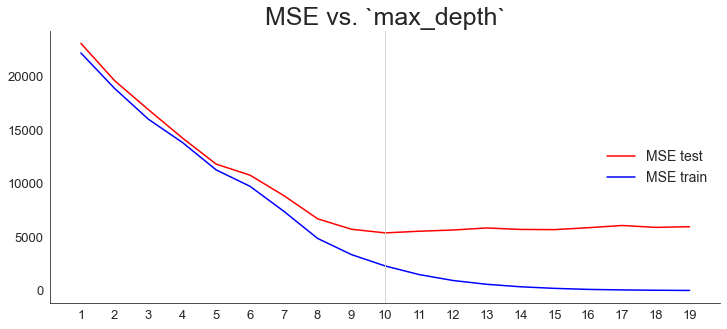

In [16]:
def plot_mse(lst, param, vert_line, loc='right'):
    plt.figure(figsize=(12, 5))
    plt.plot(lst, mse_test_lst, color='red')
    plt.plot(lst, mse_train_lst, color='blue')
    plt.title(f'MSE vs. `{param}`', fontsize=25)
    plt.xticks(lst, fontsize=13)
    plt.yticks(fontsize=13)
    plt.axvline(vert_line, color='lightgrey', linewidth=0.9)
    plt.legend(['MSE test','MSE train'], frameon=False, loc=loc, fontsize=14)
    sns.despine()
    plt.show()

plot_mse(depths, 'max_depth', 10)

Both the MSE for the test set and the one for the train set are decreasing with the maximum tree depth increasing, up to reaching a plateau at some value of the parameter. 

The lowest value of the MSE for the test set (given still a relatively small difference with the MSE for the train test) is reached when the maximum tree depth is equal to 10. Let's find the value of the `random_state` parameter (from 0 to 999) that gives the lowest error:

In [17]:
select_best_random_state(max_depth=10)

Min MSE:      5,343
Random state: 814


and reconstruct the model with this random state:

In [18]:
clf = DecisionTreeRegressor(max_depth=10, random_state=814)
mse_test, mse_train = train_and_test()
del mse_test, mse_train

MSE on the test set: 5,343
          train set: 2,301
---------------------------


The difference between the MSE values on the test and train sets is much lower than the one for the initial basic model but much higher than the one for the linear regression model, given the nature of the decision tree algorithm and its intrinsic tendency to overfitting. 

Now, let's fix the `max_depth` parameter to 10, tune another smoothing parameter `min_samples_leaf` (the minimum number of samples required to be at a leaf node), and select its value that leads to the lowest error:

MSE on the test set: 5,393
          train set: 2,301
---------------------------
MSE on the test set: 5,283
          train set: 2,448
---------------------------
MSE on the test set: 5,239
          train set: 2,615
---------------------------
MSE on the test set: 5,419
          train set: 2,783
---------------------------
MSE on the test set: 5,303
          train set: 2,873
---------------------------
MSE on the test set: 5,511
          train set: 3,081
---------------------------
MSE on the test set: 5,581
          train set: 3,249
---------------------------
MSE on the test set: 5,743
          train set: 3,459
---------------------------
MSE on the test set: 5,800
          train set: 3,554
---------------------------
MSE on the test set: 5,849
          train set: 3,682
---------------------------
MSE on the test set: 5,897
          train set: 3,810
---------------------------
MSE on the test set: 5,946
          train set: 4,179
---------------------------
MSE on the test 

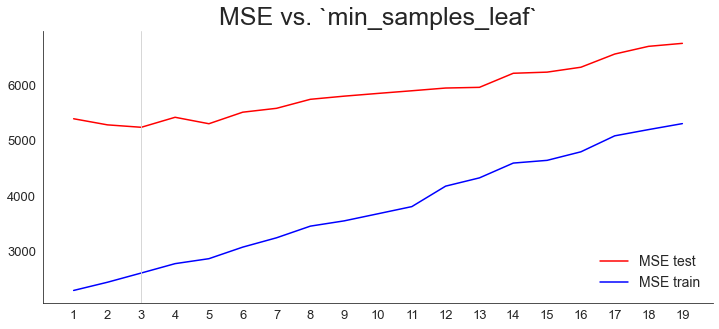

In [19]:
# Checking different values of the `min_samples_leaf` parameter
min_samples_leaf_lst = range(1, 20)
mse_test_lst = []
mse_train_lst = []
for min_samples_leaf in min_samples_leaf_lst:
    clf = DecisionTreeRegressor(max_depth=10, min_samples_leaf=min_samples_leaf, random_state=1)
    mse_test, mse_train = train_and_test()
    mse_test_lst.append(mse_test)
    mse_train_lst.append(mse_train)
    
plot_mse(min_samples_leaf_lst, 'min_samples_leaf', 3, loc='lower right')

The value of the `min_samples_leaf` parameter equal to 3 gives the lowest error for the test set and still provides a good compromise for the overfitting.

Let's check the best value of the random state and reconstruct this model:

In [20]:
select_best_random_state(max_depth=10, min_samples_leaf=3)

Min MSE:      5,161
Random state: 114


In [21]:
clf = DecisionTreeRegressor(max_depth=10, min_samples_leaf=3, random_state=114)
mse_test, mse_train = train_and_test()
del mse_test, mse_train

MSE on the test set: 5,161
          train set: 2,615
---------------------------


Another useful parameter to play with is `min_samples_split` (the minimum number of samples required to split an internal node):

MSE on the test set: 5,239
          train set: 2,615
---------------------------
MSE on the test set: 5,239
          train set: 2,615
---------------------------
MSE on the test set: 5,239
          train set: 2,615
---------------------------
MSE on the test set: 5,239
          train set: 2,615
---------------------------
MSE on the test set: 5,239
          train set: 2,615
---------------------------
MSE on the test set: 5,151
          train set: 2,645
---------------------------
MSE on the test set: 5,119
          train set: 2,675
---------------------------
MSE on the test set: 5,164
          train set: 2,689
---------------------------
MSE on the test set: 5,153
          train set: 2,706
---------------------------
MSE on the test set: 5,076
          train set: 2,733
---------------------------
MSE on the test set: 5,297
          train set: 2,827
---------------------------
MSE on the test set: 5,301
          train set: 2,864
---------------------------
MSE on the test 

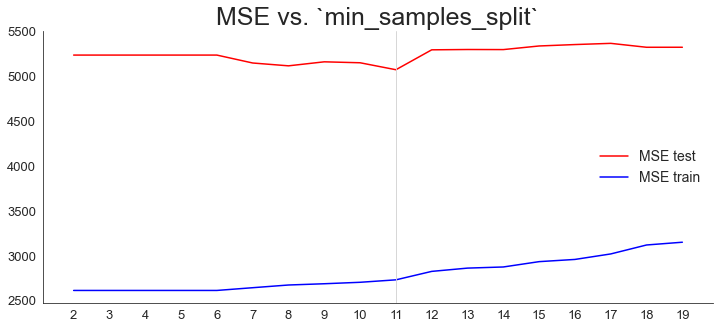

In [22]:
# Checking different values of the `min_samples_split` parameter
min_samples_split_lst = range(2, 20)
mse_test_lst = []
mse_train_lst = []
for min_samples_split in min_samples_split_lst:
    clf = DecisionTreeRegressor(max_depth=10, min_samples_leaf=3, 
                                min_samples_split=min_samples_split, random_state=1)
    mse_test, mse_train = train_and_test()
    mse_test_lst.append(mse_test)
    mse_train_lst.append(mse_train)

plot_mse(min_samples_split_lst, 'min_samples_split', 11)

The value of the `min_samples_split` parameter equal to 11 seems to be the optimal one. Let's find the best value of the random state and reconstruct this model:

In [23]:
select_best_random_state(max_depth=10, min_samples_leaf=3, min_samples_split=11)

Min MSE:      5,075
Random state: 22


In [24]:
clf = DecisionTreeRegressor(max_depth=10, min_samples_leaf=3, min_samples_split=11, 
                            random_state=22)
mse_test, mse_train = train_and_test()
del mse_test, mse_train

MSE on the test set: 5,075
          train set: 2,733
---------------------------


Now, let's compare all the models we've built so far:

Model                                                             | MSE test| MSE train|Delta
------------------------------------------------------------------|---------|----------|------
linear regression                                                 |17,603   |17,254    |349
default tree                                                      |6,160    |0         |6,160
**max_depth**=10                                                  |5,343    |2,301     |3,042
**min_samples_leaf**=3, **max_depth**=10                          |5,161    |2,615     |2,546
**min_samples_split**=11, **min_samples_leaf**=3, **max_depth**=10|5,075    |2,733     |2,342

We can make the following observations.
- The decision tree algorithm performed better than the linear regression in terms of the obtained MSE values.
- A default decision tree severely overfits.
- Tuning the decision tree parameters, we managed to significantly reduce both the error and overfitting.

### Random Forest
Now, let's apply the random forest algorithm and compare the results again.

This technique allows creating even more accurate models than the decision tree algorithm, and, at the same time, it overfits much less. The disadvantages are that the random forests take longer to create and also they are difficult to interpret because we're averaging the results of many trees.

As earlier, let's first create a random forest with default parameters:

In [25]:
clf = RandomForestRegressor(random_state=1)
mse_test, mse_train = train_and_test()
del mse_test, mse_train

MSE on the test set: 3,054
          train set: 418
---------------------------


We can see that even without tuning any parameters, the random forest algorithm produces much more precise and less overfitted models than the decision tree.

Let's adjust the number of trees in the forest, which by default is 100:

MSE on the test set: 5,128
          train set: 1,328
---------------------------
MSE on the test set: 4,264
          train set: 853
---------------------------
MSE on the test set: 3,770
          train set: 754
---------------------------
MSE on the test set: 3,611
          train set: 656
---------------------------
MSE on the test set: 3,500
          train set: 611
---------------------------
MSE on the test set: 3,302
          train set: 494
---------------------------
MSE on the test set: 3,181
          train set: 456
---------------------------
MSE on the test set: 3,118
          train set: 457
---------------------------
MSE on the test set: 3,102
          train set: 446
---------------------------
MSE on the test set: 3,095
          train set: 437
---------------------------
MSE on the test set: 3,054
          train set: 431
---------------------------
MSE on the test set: 3,056
          train set: 425
---------------------------
MSE on the test set: 3,054
          t

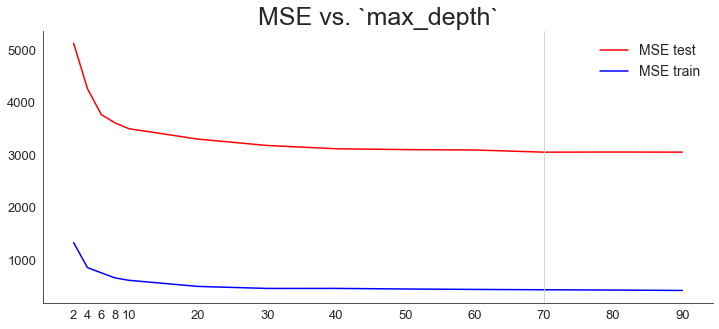

In [26]:
# Checking different values of the `n_estimators` parameter
num_of_trees_lst = list(range(2, 10, 2)) + list(range(10, 100, 10))
mse_test_lst = []
mse_train_lst = []
for num_of_trees in num_of_trees_lst:
    clf = RandomForestRegressor(n_estimators=num_of_trees, random_state=1)
    mse_test, mse_train = train_and_test()
    mse_test_lst.append(mse_test)
    mse_train_lst.append(mse_train)

plot_mse(num_of_trees_lst, 'max_depth', 70, loc='upper right')

As we can see, increasing the number of trees beyond a certain number doesn't help much to decrease the error. Anyway, from the numbers and plot above, we picked the number of trees equal to 70. Let's find the best value of the random state and reconstruct this model:

In [27]:
select_best_random_state(method='RandomForestRegressor', n_estimators=70)

Min MSE:      2,946
Random state: 494


In [28]:
clf = RandomForestRegressor(n_estimators=70, random_state=494)
mse_test, mse_train = train_and_test()
del mse_test, mse_train

MSE on the test set: 2,946
          train set: 424
---------------------------


Now, we'll repeat the same steps of parameter adjustment as we did for the decision trees, namely:
1. Tuning the `max_depth` parameter and visualizing the resulting errors.
2. Selecting the value of `max_depth` that gives the lowest error.
3. Finding the best random state and reconstructing the model.
4. Fixing the defined best value of `max_depth` and repeating the steps from 1 to 4 for the parameters `min_samples_leaf` and `min_samples_split`.

### `max_depth`

MSE on the test set: 23,103
          train set: 22,207
---------------------------
MSE on the test set: 18,672
          train set: 17,959
---------------------------
MSE on the test set: 16,139
          train set: 15,363
---------------------------
MSE on the test set: 13,470
          train set: 13,046
---------------------------
MSE on the test set: 11,079
          train set: 10,593
---------------------------
MSE on the test set: 9,393
          train set: 8,610
---------------------------
MSE on the test set: 6,290
          train set: 5,365
---------------------------
MSE on the test set: 4,638
          train set: 3,354
---------------------------
MSE on the test set: 3,914
          train set: 2,261
---------------------------
MSE on the test set: 3,501
          train set: 1,554
---------------------------
MSE on the test set: 3,274
          train set: 1,088
---------------------------
MSE on the test set: 3,145
          train set: 797
---------------------------
MSE on t

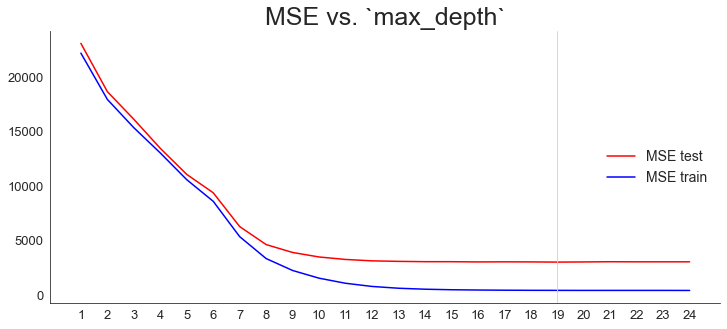

In [29]:
# Checking different values of the `max_depth` parameter
depths = range(1, 25)
mse_test_lst = []
mse_train_lst = []
for depth in depths:
    clf = RandomForestRegressor(n_estimators=70, max_depth=depth, random_state=1)
    mse_test, mse_train = train_and_test()
    mse_test_lst.append(mse_test)
    mse_train_lst.append(mse_train)

plot_mse(depths, 'max_depth', 19)

In [30]:
select_best_random_state(method='RandomForestRegressor', n_estimators=70, max_depth=19)

Min MSE:      2,941
Random state: 494


In [31]:
clf = RandomForestRegressor(n_estimators=70, max_depth=19, random_state=494)
mse_test, mse_train = train_and_test()
del mse_test, mse_train

MSE on the test set: 2,941
          train set: 426
---------------------------


### `min_samples_leaf`

MSE on the test set: 3,031
          train set: 438
---------------------------
MSE on the test set: 3,105
          train set: 800
---------------------------
MSE on the test set: 3,309
          train set: 1,217
---------------------------
MSE on the test set: 3,490
          train set: 1,611
---------------------------
MSE on the test set: 3,673
          train set: 1,950
---------------------------
MSE on the test set: 3,841
          train set: 2,246
---------------------------
MSE on the test set: 4,040
          train set: 2,543
---------------------------
MSE on the test set: 4,197
          train set: 2,780
---------------------------
MSE on the test set: 4,372
          train set: 3,030
---------------------------
MSE on the test set: 4,516
          train set: 3,264
---------------------------
MSE on the test set: 4,658
          train set: 3,482
---------------------------
MSE on the test set: 4,811
          train set: 3,687
---------------------------
MSE on the test set:

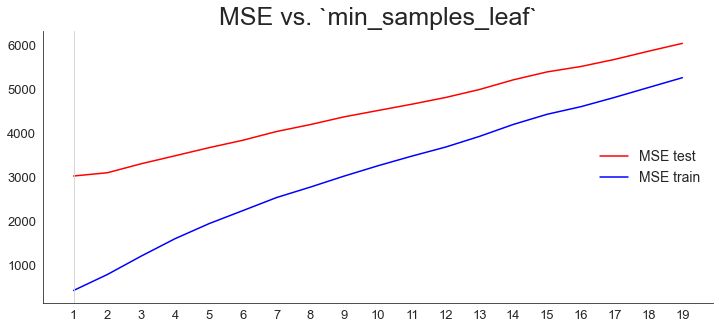

In [32]:
# Checking different values of the `min_samples_leaf` parameter
min_samples_leaf_lst = range(1, 20)
mse_test_lst = []
mse_train_lst = []
for min_samples_leaf in min_samples_leaf_lst:
    clf = RandomForestRegressor(n_estimators=70, max_depth=19, 
                                min_samples_leaf=min_samples_leaf, random_state=1)
    mse_test, mse_train = train_and_test()
    mse_test_lst.append(mse_test)
    mse_train_lst.append(mse_train)

plot_mse(min_samples_leaf_lst, 'min_samples_leaf', 1)

The lowest error is obtained when the `min_samples_leaf` parameter is equal to 1, which is actually its default value. Hence, we still have the same model as before, where `n_estimators`=70, `max_depth`=19, and `random_state`=494.
### `min_samples_split`

MSE on the test set: 3,031
          train set: 438
---------------------------
MSE on the test set: 3,047
          train set: 500
---------------------------
MSE on the test set: 3,078
          train set: 594
---------------------------
MSE on the test set: 3,082
          train set: 696
---------------------------
MSE on the test set: 3,104
          train set: 804
---------------------------
MSE on the test set: 3,145
          train set: 915
---------------------------
MSE on the test set: 3,186
          train set: 1,024
---------------------------
MSE on the test set: 3,220
          train set: 1,142
---------------------------
MSE on the test set: 3,271
          train set: 1,252
---------------------------
MSE on the test set: 3,337
          train set: 1,371
---------------------------
MSE on the test set: 3,374
          train set: 1,481
---------------------------
MSE on the test set: 3,430
          train set: 1,595
---------------------------
MSE on the test set: 3,493
 

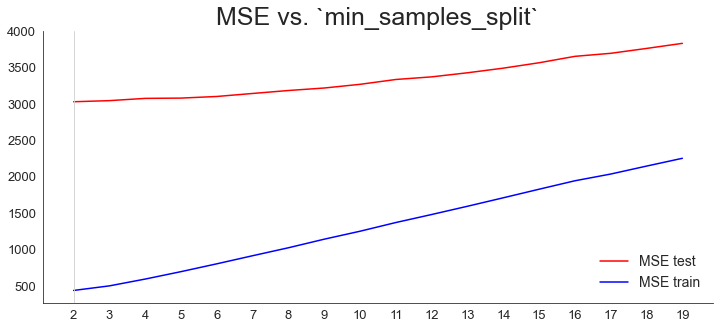

In [33]:
# Checking different values of the `min_samples_split` parameter
min_samples_split_lst = range(2, 20)
mse_test_lst = []
mse_train_lst = []
for min_samples_split in min_samples_split_lst:
    clf = RandomForestRegressor(n_estimators=70, max_depth=19, 
                                min_samples_split=min_samples_split, random_state=1)
    mse_test, mse_train = train_and_test()
    mse_test_lst.append(mse_test)
    mse_train_lst.append(mse_train)

plot_mse(min_samples_split_lst, 'min_samples_split', 2, loc='lower right')

Also here the lowest error corresponds to the default value of the `min_samples_split` parameter, meaning that this adjustment doesn't really make sense, and the previous model remains unchanged: `n_estimators`=70, `max_depth`=19, and `random_state`=494.

Let's overview all the models we created so far:

Model                                                             | MSE test| MSE train|Delta
------------------------------------------------------------------|---------|----------|------
linear regression                                                 |17,603   |17,254    |349
default tree                                                      |6,160    |0         |6,160
**max_depth**=10                                                  |5,343    |2,301     |3,042
**min_samples_leaf**=3, **max_depth**=10                          |5,161    |2,615     |2,546
**min_samples_split**=11, **min_samples_leaf**=3, **max_depth**=10|5,075    |2,733     |2,342
default random forest                                             |3,054    |418       |2,636
**n_estimators**=70                                               |2,946    |424       |2,522
**max_depth**=19, **n_estimators**=70                             |2,941    |426       |2,515

As we can observe, the last model is the most accurate one, so it can be used to predict unseen data.

## Conclusion
In this project, we've applied the linear regression, decision tree, and random forest machine learning techniques to predict the total number of bikes people rent in a given hour in Washington, D.C. Below are our main results:
- Using the linear regression algorithm, we obtained a model with rather high values of MSE on both train and test sets.


- Using the decision tree algorithm, we initially obtained a heavily overfitted model, but with the error much lower than that for the linear regression model. Tuning the decision tree parameters, we managed to significantly reduce overfitting and further reduce the error.


- Using the random forest algorithm, we built the most accurate models with moderate overfitting. Tuning the parameters we further decreased the error of predictions, but even with the default values of parameters, the random forest algorithm, due to its averaging nature, performed much better than the linear regression and decision tree algorithms.  


- The model recommended to be used for bike rental predictions is a random forest model with 70 trees and the maximum tree depth equal to 19.